<a href="https://colab.research.google.com/github/TruongHieuDEV/MachineLearning/blob/main/ml_exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [213]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
from sklearn import model_selection
%matplotlib inline

In [214]:
#notice: Disable all warnings 
import warnings
warnings.filterwarnings('ignore')

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [215]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2023-06-05 12:24:38--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.02s   

2023-06-05 12:24:38 (1.40 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [216]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [217]:
df.shape

(346, 10)

### Convert to date time object


In [218]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [219]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [220]:
# notice: installing seaborn might takes a few minutes
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


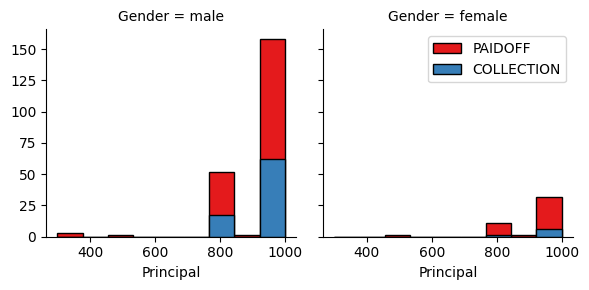

In [221]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

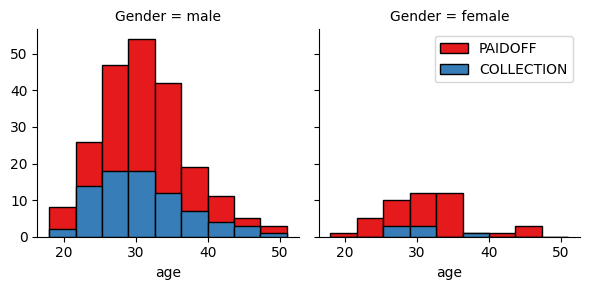

In [222]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()



```
# This is formatted as code
```

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


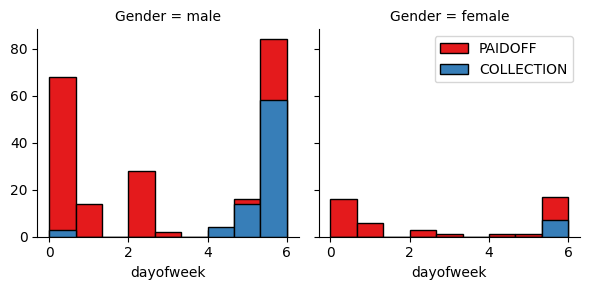

In [223]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [224]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [225]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [226]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [227]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [228]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [229]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [230]:
X = Feature


What are our lables?


In [231]:
y = df['loan_status'].values


## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [232]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

In [233]:
X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y, test_size=0.2, random_state=4)

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [234]:
from sklearn import neighbors
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

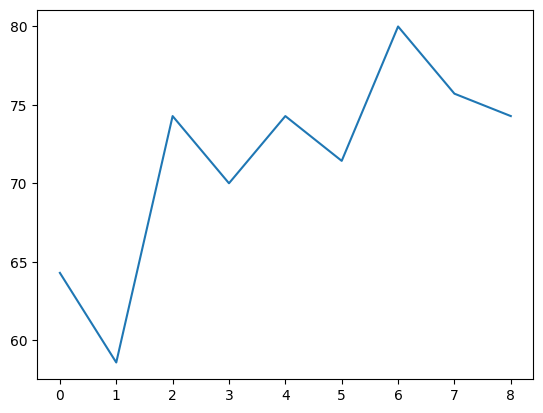

In [235]:
accuracy = []
for k in range(1, 10):
  Kmean = neighbors.KNeighborsClassifier(n_neighbors=k, algorithm="kd_tree")
  Kmean.fit(X_train, y_train)
  y_pred = Kmean.predict(X_val)
  accuracy.append((100*accuracy_score(y_val, y_pred)))
plt.plot(accuracy)
#k = 7
Kmean = neighbors.KNeighborsClassifier(n_neighbors=7)
Kmean.fit(X_train, y_train)
y_pred = Kmean.predict(X_val)
y_pred_train = Kmean.predict(X_train)

In [236]:
print("Accuracy of 4NN for test: %.2f %%" %(100*accuracy_score(y_train, y_pred_train)))
print("Accuracy of 4NN for validation: %.2f %%" %(100*accuracy_score(y_val, y_pred)))

Accuracy of 4NN for test: 80.43 %
Accuracy of 4NN for validation: 80.00 %


# Decision Tree


In [237]:
from sklearn.tree import DecisionTreeClassifier

In [238]:
DTree = DecisionTreeClassifier(criterion='entropy').fit(X_train, y_train)

In [239]:
print("Accuracy of descition tree for test: %.2f %%" %(100*accuracy_score(y_train, DTree.predict(X_train))))
print("Accuracy of  descition tree for validation: %.2f %%" %(100*accuracy_score(y_val,DTree.predict(X_val))))

Accuracy of descition tree for test: 90.94 %
Accuracy of  descition tree for validation: 68.57 %


# Support Vector Machine


In [240]:
from sklearn.svm import SVC

In [241]:
SVMachine = SVC(C=1e5, kernel="linear").fit(X_train, y_train)

In [242]:
print("Accuracy of SVM model for test: %.2f %%" %(100*accuracy_score(y_train, SVMachine.predict(X_train))))
print("Accuracy of  SVM model for validation: %.2f %%" %(100*accuracy_score(y_val,SVMachine.predict(X_val))))

Accuracy of SVM model for test: 75.00 %
Accuracy of  SVM model for validation: 74.29 %


# Logistic Regression


In [243]:
from sklearn.linear_model import LogisticRegression

In [244]:
LogRegression = LogisticRegression(C=1, solver="liblinear", penalty='l2').fit(X_train, y_train)

In [245]:
print("Accuracy of Logistic Regression Model for test: %.2f %%" %(100*accuracy_score(y_train, LogRegression.predict(X_train))))
print("Accuracy of Logistic Regression Model for validation: %.2f %%" %(100*accuracy_score(y_val,LogRegression.predict(X_val))))

Accuracy of Logistic Regression Model for test: 76.45 %
Accuracy of Logistic Regression Model for validation: 71.43 %


# Model Evaluation using Test set


In [246]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [247]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2023-06-05 12:26:20--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2023-06-05 12:26:20 (622 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [248]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [249]:
def preProcessing(df):
  df['due_date'] = pd.to_datetime(df['due_date'])
  df['effective_date'] = pd.to_datetime(df['effective_date'])
  df['dayofweek'] = df['effective_date'].dt.dayofweek
  df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
  df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
  Feature = df[['Principal','terms','age','Gender','weekend']]
  Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
  Feature.drop(['Master or Above'], axis = 1,inplace=True)
  X = Feature
  X = preprocessing.StandardScaler().fit(X).transform(X)
  y = df['loan_status'].values
  return X, y
X_test, y_test = preProcessing(test_df)


In [251]:
def evaluate(model, X, y):
  print(f"Jaccard: {jaccard_score(y, model.predict(X), pos_label='PAIDOFF')}")
  print(f"F1: {f1_score(y, model.predict(X), pos_label='PAIDOFF')}")
evaluate(Kmean, X_test, y_test)

Jaccard: 0.6666666666666666
F1: 0.7999999999999998


In [252]:
evaluate(DTree, X_test, y_test)

Jaccard: 0.6595744680851063
F1: 0.7948717948717949


In [254]:
evaluate(SVMachine, X_test, y_test)

Jaccard: 0.7647058823529411
F1: 0.8666666666666667


In [256]:
evaluate(LogRegression, X_test, y_test)
print(f"log loss: {log_loss(y_test, LogRegression.predict_proba(X_test))}")

Jaccard: 0.75
F1: 0.857142857142857
log loss: 0.46899782059214606


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | 0.67       | 0.8        | NA      |
| Decision Tree      | 0.66       | 0.79        | NA      |
| SVM                | 0.76       | 0.87        | NA      |
| LogisticRegression | 0.75       | 0.86        | 0.47       |
